<a href="https://colab.research.google.com/github/JahnaviRamagiri/EVA-B2/blob/master/S5/S5_Exp3_Global_Average_Pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 3**

Target: To Reduce Parameters using GAP - Global Average Pooling
1.	Add GAP, slight changes made to the model
2.	Reduce batch size (as the no. of parameters are assumed to be reduced on usage of GAP)

Results:
1.	Parameters: 9752
2.	Best Training Accuracy: 
•	99.16 	(GAP and batch size =128)  	
•	99.28 (GAP and Batchsize=64) (19th epoch)

3.	Best Test Accuracy: 
•	99.35 (GAP and batch size = 128) 	
•	99.47 (GAP and Batchsize=64) (19th epoch)

Analysis:
1.	GAP layer of 8 kernels is used. If we reduce the kernels, more would be the convolutions and thus there is a chance to increase the accuracies but at the cost of increasing parameters.
2.	Adding GAP layer has decreased no. of parameters and yet accuracy increased : GAP is working
3.	Parameters have come below 10k: **Parameter target reached**. (Reducing kernels in GAP would increase parameters and thus, let us stick to this size.)
4.	Accuracy of 99.47 could be hit (though not consistent) at the 19th epoch (though not in less than 15 epochs) 
5.	Reducing the Batchsize resulted in more iterations for training and thus has further increased the accuracy: Reducing batch size worked. Further reducing batchsize could be experimented with.


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations




In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
                               #        Nin P K S No  Ro  J  
                               #         -  - - - 28  1   1
        x = self.convblock1(x) #        28  0 3 1 26  3   1
        x = self.convblock2(x) #        26  0 3 1 24  5   1    
        x = self.pool1(x)      #        24  0 2 2 12  6   1
        x = self.convblock3(x) #        12  0 1 1 12  6   2
        x = self.convblock4(x) #        12  0 3 1 10  10  2
        x = self.convblock5(x) #        10  0 3 1 8   14  2
        x = self.convblock6(x) #        8   1 3 1 8   18  2
        x = self.convblock7(x) #        8   1 3 1 8   22  2
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing



In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
   

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.28478458523750305 Batch_id=937 Accuracy=92.42: 100%|██████████| 938/938 [00:13<00:00, 67.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.039726391434669495 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:14<00:00, 63.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.03590719401836395 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:14<00:00, 65.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.003919273614883423 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:14<00:00, 65.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.0015846341848373413 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:14<00:00, 65.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.020572781562805176 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:14<00:00, 65.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.2453906089067459 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:14<00:00, 65.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.009099647402763367 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:14<00:00, 64.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.01728735864162445 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:14<00:00, 65.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.012510791420936584 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:14<00:00, 66.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.00039568543434143066 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:14<00:00, 66.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.0021389424800872803 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:14<00:00, 64.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.0037498027086257935 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:14<00:00, 65.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.0029236823320388794 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:14<00:00, 65.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.0064062923192977905 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:14<00:00, 66.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.08518756926059723 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:14<00:00, 66.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.0023089945316314697 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:14<00:00, 66.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.03823709487915039 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:14<00:00, 65.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.002218768000602722 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:14<00:00, 66.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.030238397419452667 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:14<00:00, 66.01it/s]



Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

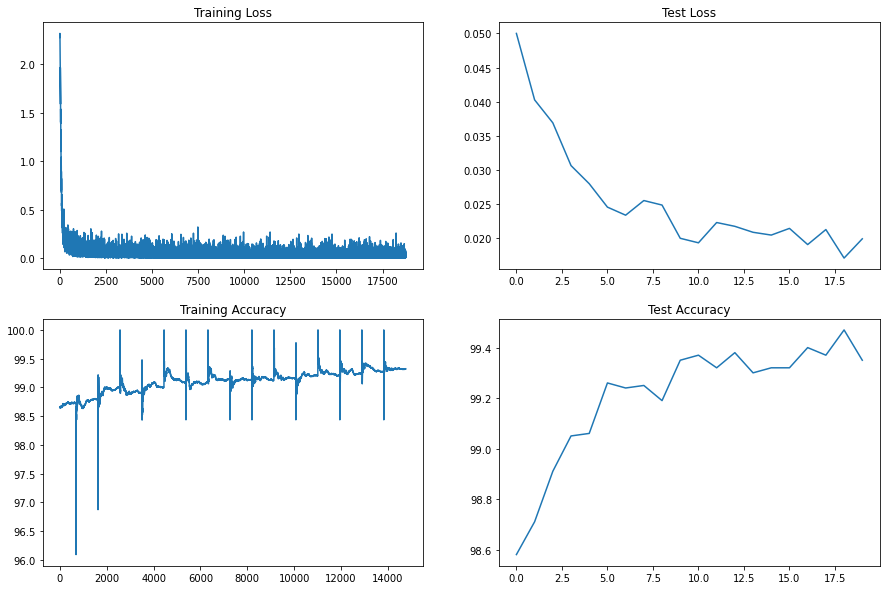

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")